# Contanti vs. Education and Age

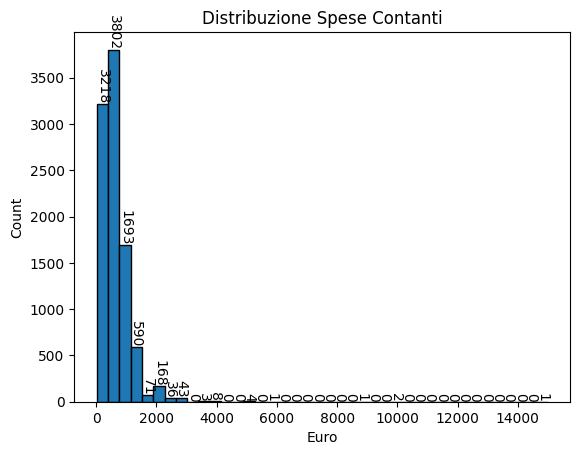

In [1]:
import polars as pl
import matplotlib.pyplot as plt
from BI_microdata_extractor import BIMicrodataExtractor

bfi = BIMicrodataExtractor()
bfi.load_data("BFI_2022")

counts, bins, patches = plt.hist(bfi.df_families["SPESECON"].to_numpy(), bins=40, edgecolor='black')

for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)),
             ha='center', va='bottom',rotation=-90)

plt.title("Distribuzione Spese Contanti")
plt.xlabel("Euro")
plt.ylabel("Count")
plt.show()

### Define general processing and plotting function for "spesa in contanti"
### ⚠️ Nota

L'età è filtrata per avere solo individui maggiorenni.

Poiché l'informazione di spesa in contanti mensile è relativa al nucleo familiare, le variabili **"età"** e **"educazione"** sono aggregate nella **media degli individui maggiorenni** del nucleo familiare.

In [2]:
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(
        joint_prob_matrix,
        labels_attrib,
        title: str = None,
        x_label: str = None,
        y_label: str = "Monthly Cash Expanses",
    ):
    bins_spese = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 20000]

    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(
        joint_prob_matrix[:,1:],
        cmap="viridis",
        annot=True,
        fmt=".4f"
    )

    # Set x and y labels
    xticks = joint_prob_matrix.columns[1:]
    yticks = joint_prob_matrix.select(pl.col("SPESECON")).to_series().unique().sort(descending=True)
    ax.set_xticks([el+0.5 for el in range(len(xticks))])
    ax.set_xticklabels([labels_attrib.get(int(val)) for val in xticks], rotation=45, ha='right')

    # Create the mapping_spese dictionary
    mapping_spese = {}
    for i, el in enumerate(bins_spese):
        mapping_spese[f"[{el}, {bins_spese[i+1]})"] = i+1
        if i+1 == len(bins_spese)-1:
            break
    
    labels_spese = dict((v,k) for k,v in mapping_spese.items())

    ax.set_yticks([el+0.5 for el in range(len(yticks))])
    ax.set_yticklabels([labels_spese.get(val) for val in yticks], rotation=0, ha='right')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def contanti(
        bfi: BIMicrodataExtractor,
        attribute: str,
        bins: List=None,
        bins_spese = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 20000],
):    
    """
    Computes the joint probability distribution of a given attribute against monthly cash expenses (SPESECON).
    Parameters:
    - bfi: BIMicrodataExtractor instance containing the Banca d'Italia data.
    - attribute: The attribute to analyze (e.g., "STUDIO", "ETA").
    - bins: Optional list of bins to categorize the attribute values.
    - bins_spese: Bins for monthly cash expenses (default provided).
    """
    # 1. First processing depending in which dataframe the attribute is (in bfi.df_familymembers or df.families)
    if attribute in bfi.df_familymembers.columns:       
        # Filtro i maggiorenni
        rules = [("ETA",">=",18)]
        df = bfi.filter(rules, bfi.df_familymembers)

        # Group by NQUEST and compute mean of attribute
        df_agg = df.group_by("NQUEST").agg([
            pl.col(attribute).mean().floor().alias(attribute).cast(pl.Int64),
        ])

        # Join df_agg with Banca d'Italia families df and select relevant columns
        df_agg = df_agg.join(bfi.df_families, on="NQUEST", how="left").select("NQUEST", attribute, "SPESECON")
    else:
        df_agg = bfi.df_families.select("NQUEST", attribute, "SPESECON")

    # Compute joint distributions for education and age against spese contanti
    df_joint,_ = bfi.joint_distribution(attrs=[attribute,"SPESECON"], df=df_agg)

    # 2. Cut the spese contanti into bins
    df_joint = df_joint.with_columns(
        [
            df_joint["SPESECON"].cut(
                breaks=bins_spese,
                left_closed=True
            ).alias("SPESECON")
        ])
    
    # Create the mapping_spese dictionary
    mapping_spese = {}
    for i, el in enumerate(bins_spese):
        mapping_spese[f"[{el}, {bins_spese[i+1]})"] = i+1
        if i+1 == len(bins_spese)-1:
            break
            
    # Replace SPESECON values with the mapping
    df_joint = df_joint.with_columns([
    df_joint["SPESECON"].replace_strict(mapping_spese).alias("SPESECON"),
    ])

    # 3. Cut the attribute into bins
    if bins:    
        df_joint = df_joint.with_columns(
        [
            df_joint[attribute].cut(
                breaks=bins,
                left_closed=True
            ).alias(attribute)
        ])
        
        # Create the mapping dictionary
        mapping = {}
        for i, el in enumerate(bins):
            mapping[f"[{el}, {bins[i+1]})"] = i+1
            if i+1 == len(bins)-1:
                break
        
        # Replace the attribute values with the mapping
        df_joint = df_joint.with_columns([
            df_joint[attribute].replace_strict(mapping).alias(attribute),
        ])

    # 4. Group by the attribute and SPESCON
    df_merged = df_joint.group_by([attribute, "SPESECON"]).agg([
        pl.col("count").sum().alias("count"),
        pl.col("prob").sum().alias("prob")
    ])

    # 5. Compute the joint probability matrix
    joint_prob_matrix = (
        df_merged
        .pivot(
            values="prob",
            index="SPESECON", # Rows
            on=attribute,     # Columns
            aggregate_function="first"  # assuming each pair is unique
        )
        .fill_null(0) # Fill NaN with 0
        .with_columns(pl.col("SPESECON").cast(pl.Int32))
        .sort("SPESECON", descending=True)  # Sort cash_expenses descending (top to bottom)
    )

    # Sort columns by age ascending (left to right)
    attrib_cols = sorted(
        [int(col) for col in joint_prob_matrix.columns if col != "SPESECON"]
    )
    attrib_cols_str = [str(col) for col in attrib_cols]

    joint_prob_matrix = joint_prob_matrix.select(["SPESECON"] + attrib_cols_str)

    # 6. plot the results
    if bins:
        labels_attrib = dict((v,k) for k,v in mapping.items())
    else:
        labels_attrib = bfi.get_attribute_metadata(attribute)

    title = f"Monthly Cash Expanses vs. {attribute}\n\nJoint Probability Distribution Heatmap"
    
    plot_heatmap(
        joint_prob_matrix,
        labels_attrib,
        title=title,
        x_label=attribute
    )

    return joint_prob_matrix

## Contanti vs. Age

File BFI_2022/METADATI/Classificazioni/BFI_Classificazione_2022_varC17.csv does not exist.

Attribute n° C17 (SPESECON) may be of numerical type.


/tmp/ipykernel_5475/3743819495.py:96: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df_joint["SPESECON"].replace_strict(mapping_spese).alias("SPESECON"),
/tmp/ipykernel_5475/3743819495.py:118: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df_joint[attribute].replace_strict(mapping).alias(attribute),


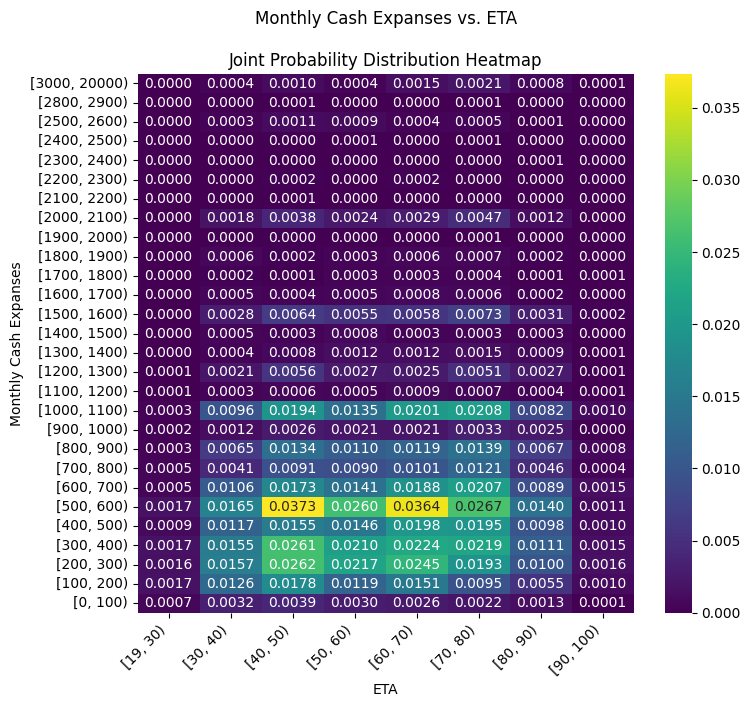

In [ ]:
bins_eta = [19, 30, 40, 50, 60, 70, 80, 90, 100]  
contanti_age_matrix = contanti(bfi, "ETA", bins_eta)

### Normalized marginal distributions (conditional probabilities)

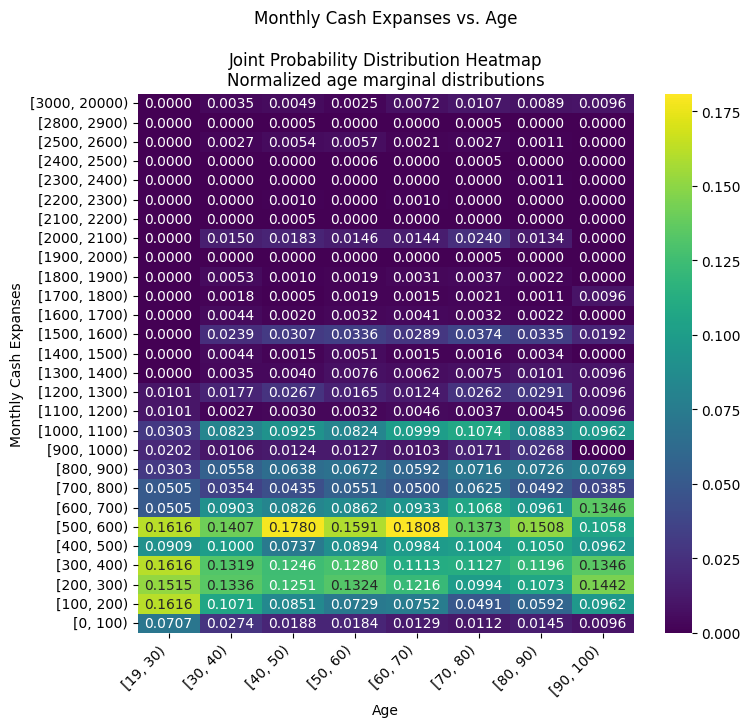

In [4]:
# Marginal normalization
contanti_age_matrix_norm = contanti_age_matrix.with_columns([
    (pl.col(col) / pl.col(col).sum()).alias(col) for col in contanti_age_matrix.columns[1:]
])

# Plot
mapping = {}
for i, el in enumerate(bins_eta):
    mapping[f"[{el}, {bins_eta[i+1]})"] = i+1
    if i+1 == len(bins_eta)-1:
        break
labels_eta = dict((v,k) for k,v in mapping.items())
plot_heatmap(
        contanti_age_matrix_norm,
        labels_eta,
        title = "Monthly Cash Expanses vs. Age\n\nJoint Probability Distribution Heatmap\nNormalized age marginal distributions",
        x_label = "Age",
    )

## Contanti vs. Education

File BFI_2022/METADATI/Classificazioni/BFI_Classificazione_2022_varC17.csv does not exist.

Attribute n° C17 (SPESECON) may be of numerical type.


/tmp/ipykernel_5475/3743819495.py:96: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df_joint["SPESECON"].replace_strict(mapping_spese).alias("SPESECON"),


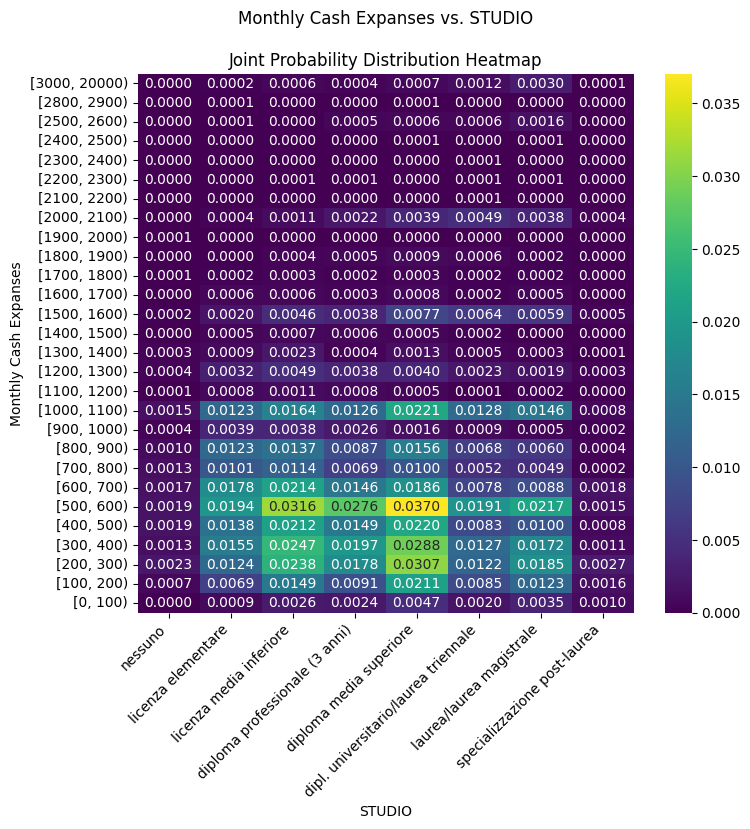

In [5]:
contanti_edu_matrix = contanti(bfi, "STUDIO")

### Normalized marginal distributions (conditional probabilities)

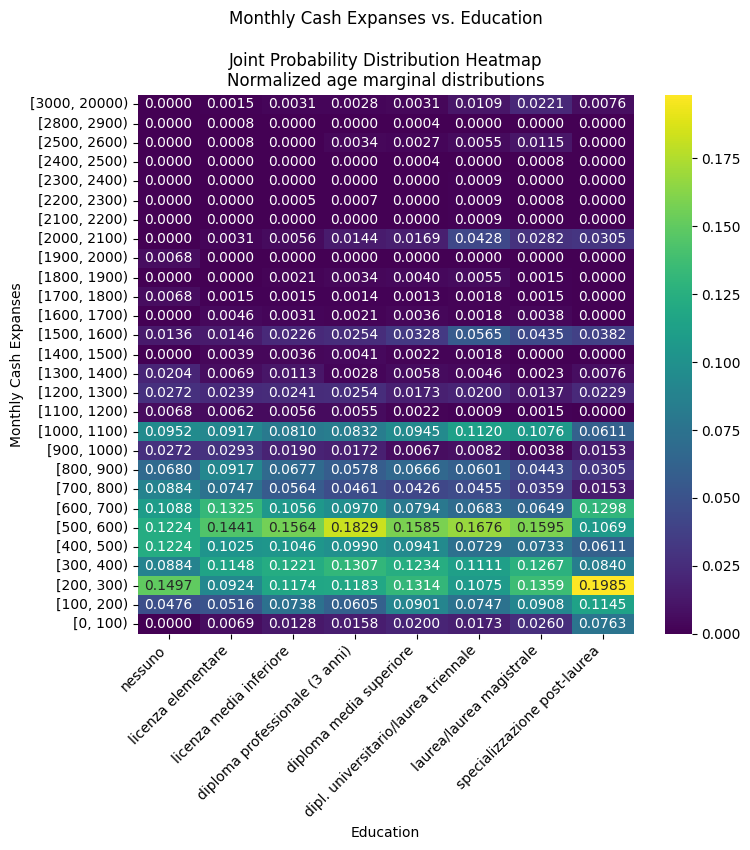

In [6]:
# Conditional probability - Normalized marginal distributions
contanti_edu_matrix_norm = contanti_edu_matrix.with_columns([
    (pl.col(col) / pl.col(col).sum()).alias(col) for col in contanti_edu_matrix.columns[1:]
])

# Plot
labels_edu = bfi.get_attribute_metadata("STUDIO")
plot_heatmap(
        contanti_edu_matrix_norm,
        labels_edu,
        title = "Monthly Cash Expanses vs. Education\n\nJoint Probability Distribution Heatmap\nNormalized age marginal distributions",
        x_label = "Education",
    )